In [1]:
import numpy as np
import matplotlib.pyplot as plt

class PDWorld_env:
    def __init__(self, alpha = 0.3):
        self.grid_size = 5
        self.num_agents = 3
        self.num_pickups = 3
        self.num_dropoffs = 3
        self.state_size = self.grid_size ** 2
        self.action_size = 6 # Up, Down, Left, Right, Pickup, Dropoff
        self.q_tables = [{} for _ in range(self.num_agents)]  # Q-table for each agent
        self.alpha = alpha  
        self.gamma = 0.5  
        self.epsilon = 0.1
        
        
        # ADDED VIZ THINGS
        self.reward_grid = np.zeros((self.grid_size, self.grid_size))

    def get_state(self):
        # Return the current state of the environment
        agent_positions = ''.join([f'{x}{y}' for x, y in self.agents])
        agent_flags = ''.join(['1' if picked else '0' for picked in self.carries_block])
        dropoff_flags = ''.join(['1' if self.blocks_on_ground.get((x, y), 0) == 4 else '0' for x, y in self.dropoffs])
        return agent_positions + agent_flags + dropoff_flags
    
    def reset(self):
        self.agents = [(2, 0), (2, 2), (2, 4)]  # Initial positions of agents
        self.pickups = [(4, 0), (3, 1), (1, 4)]  # Pickup spots
        self.dropoffs = [(0, 0), (0, 2), (4, 3)]  # Dropoff spots
        # self.passenger_picked = [False] * self.num_agents
        self.carries_block = [False] * self.num_agents
        self.blocks_on_ground = {(x, y): 4 if (x, y) in self.pickups else 0 for x in range(self.grid_size) for y in range(self.grid_size)}

        return self.get_state() 
    


    # Perform actions and calculate rewards
    def step(self, action):

        reward = 0
        state = self.get_state()

                
        for i in range(3):
            x, y = self.agents[i]  # Extract x and y coordinates

            if action == 0 and all((x, y - 1) != agent for agent in self.agents):  # Up
                if y > 0:
                    self.agents[i] = (x, y - 1)
                    reward -= 1
                    # ADDED VISUALIZATION:
                    self.reward_grid[self.agents[i]] += reward * 0.01

            elif action == 1 and all((x, y + 1) != agent for agent in self.agents):  # Down
                if y < self.grid_size - 1:
                    self.agents[i] = (x, y + 1)
                    reward -= 1
                    # ADDED VISUALIZATION:
                    self.reward_grid[self.agents[i]] += reward * 0.01

            elif action == 2 and all((x - 1, y) != agent for agent in self.agents):  # Left
                if x > 0:
                    self.agents[i] = (x - 1, y)
                    reward -= 1
                    # ADDED VISUALIZATION:
                    self.reward_grid[self.agents[i]] += reward * 0.01

            elif action == 3 and all((x + 1, y) != agent for agent in self.agents):  # Right
                if x < self.grid_size - 1:
                    self.agents[i] = (x + 1, y)
                    reward -= 1
                    # ADDED VISUALIZATION:
                    self.reward_grid[self.agents[i]] += reward * 0.01

            elif action == 4:  # Pick up
                # Pick up passenger if at pick-up spot, passenger not already picked up, and there is at least one block
                if (x, y) in self.pickups and (x, y) in self.blocks_on_ground and not self.carries_block[i]:
                    # self.passenger_picked[i] = True
                    reward += 13  # Add reward for picking up passenger
                   
                   
                    # print("PICKED UP IN CLASS") 
                    # ADDED VISUALIZATION:
                    self.reward_grid[self.agents[i]] += reward * 0.01

                    self.blocks_on_ground.pop((x, y), None)  # Remove block from the pickup cell
                    self.carries_block[i] = True

            elif action == 5:  # Drop off
                # Drop off passenger if at drop-off spot, passenger picked up, agent carries a block, and dropoff cell has less than 4 blocks
                if (x, y) in self.dropoffs and self.carries_block[i] and self.blocks_on_ground.get((x, y), 0) < 4:
                    # self.passenger_picked[i] = False
                    reward += 13
                    
                    
                    # print("DROPPED OFF IN CLASS")
                    # ADDED VISUALIZATION:
                    self.reward_grid[self.agents[i]] += reward * 0.01

                    self.blocks_on_ground[(x, y)] = self.blocks_on_ground.get((x, y), 0) + 1  # Place block on the dropoff cell
                    self.carries_block[i] = False  # Update agent's state to not carrying a block


        # Call update_q_table after all actions have been taken
        
        self.update_q_table(i, state, action, reward, self.get_state())

        return self.get_state(), reward
    
    
    
    def update_q_table(self, agent_id, state, action, reward, next_state):
            # Get Q-values for the current state
            key = str(state)
            q_values = self.q_tables[agent_id].setdefault(key, np.zeros(self.action_size))
            # print("key: ", key)
            # Get the maximum Q-value for the next state
            key_next = str(next_state)
            next_q_values = self.q_tables[agent_id].setdefault(key_next, np.zeros(self.action_size))
            max_next_q_value = np.max(next_q_values)
            # Update Q-value for the taken action
            q_values[action] += self.alpha * (reward + self.gamma * max_next_q_value - q_values[action])
            
            
    def get_q_values(self, agent_id, state):
        return self.q_tables[agent_id].setdefault(key, np.zeros(self.action_size))
    
    # ADDED REWARD GRID VISUALIZATION
    def show_reward_grid(self):
        plt.imshow(self.reward_grid, cmap='RdBu', interpolation='nearest')
        
        
        #SOMETHING IS WEIRD SOMEWHERE: j and i switched in reward_grid
        for i in range (self.grid_size):
            for j in range(self.grid_size):
                plt.text(i, j, '%.2f'%(self.reward_grid[j, i]), ha="center")
        plt.show()
            
    def is_done(self):
        #All dropoff spots have 4 blocks
        all_dropoffs_full = all(self.blocks_on_ground.get(dropoff) == 4 for dropoff in self.dropoffs)
        
        # All agents are not carrying any blocks
        all_agents_not_carrying = all(not carrying_block for carrying_block in self.carries_block)


        episode_done =  all_dropoffs_full and all_agents_not_carrying

        return episode_done


In [2]:
import matplotlib.pyplot as plt

# Function to visualize Environment
# Dropoff spots = yellow; pickup spots = green; agents = blue
def visualize_world(agents, pickups, dropoffs, grid_size):
    grid = np.zeros((grid_size, grid_size))
    
    for agent in agents:
        grid[agent] = 1
    
    for pickup in pickups:
        grid[pickup] = 2
    
    for dropoff in dropoffs:
        grid[dropoff] = 3
    
    plt.imshow(grid, cmap='viridis', interpolation='nearest')
    plt.title("Pickup: Green,    Dropoff: Yellow")
    plt.show()
    
def visualize_world_sansAgents(pickups, dropoffs, grid_size):
    grid = np.zeros((grid_size, grid_size))
    
    # for agent in agents:
    #     grid[agent] = 1
    
    for pickup in pickups:
        grid[pickup] = 2
    
    for dropoff in dropoffs:
        grid[dropoff] = 3
    
    plt.imshow(grid, cmap='viridis', interpolation='nearest')
    plt.title("Pickup: Green,    Dropoff: Yellow")
    plt.show()

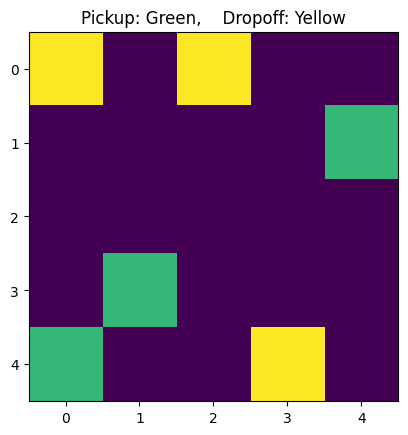

Steps completed. Reward =  -540


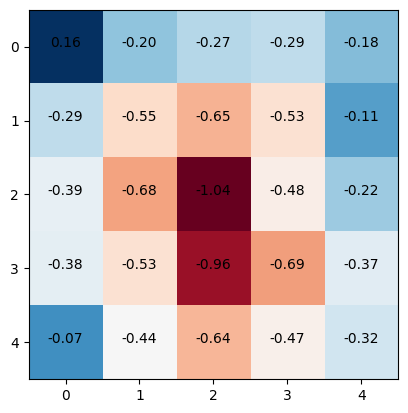

In [3]:
# Experiment 1 (first 500 steps)
# Create an instance of PDWorld_env
env = PDWorld_env(alpha = 0.3)

# Reset the environment to initialize the state
state = env.reset()
total_reward = 0

# Show Inital World
visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Set a fixed seed for reproducibility
np.random.seed(42)

# Run PRandom for the first 500 steps
for step in range(500):
    # Randomly select actions for each agent

    action = np.random.randint(0, env.action_size)
    
    # Perform actions and calculate rewards
    state, reward = env.step(action)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed. Reward = ", total_reward)

env.show_reward_grid()


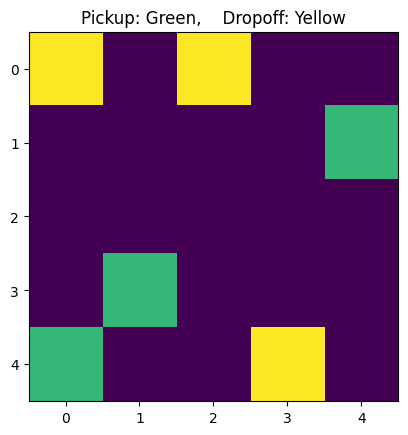

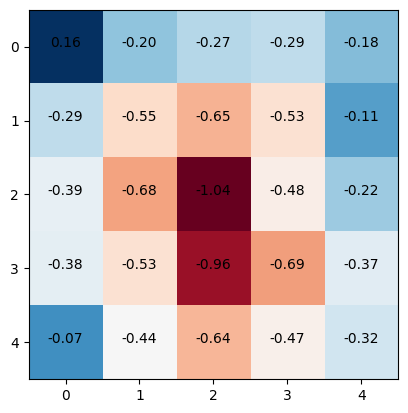

Steps completed. Reward =  -11256


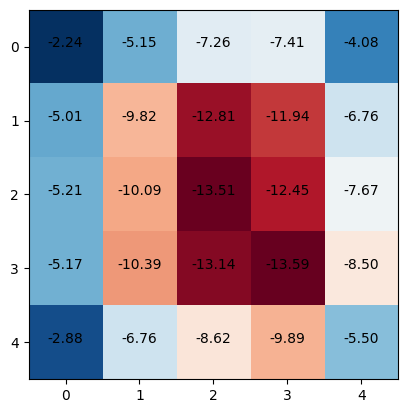

In [4]:
# Experiment 1A (Run first 500 steps)
# Continue PRandom policy

# Added copied environments so each expeiment continues from same point
env_1A = PDWorld_env()
state = env_1A.reset()
total_reward = 0
# Set a fixed seed for reproducibility
np.random.seed(42)

visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Run PRandom for the first 500 steps (1A)
for step in range(500):
    # Randomly select actions for each agent

    action = np.random.randint(0, env_1A.action_size)
    
    # Perform actions and calculate rewards
    state, reward = env_1A.step(action)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env_1A.is_done():
        print("Episode done at step", step + 1)
        break

# Show reward grid after 500 random steps
env_1A.show_reward_grid()

# Now other 8500 RANDOM steps
for step in range(8500):
    # Randomly select actions for each agent
    action = np.random.randint(0, env_1A.action_size)
    
    # Perform actions and calculate rewards
    state, reward = env_1A.step(action)  # Initial total reward is 0
    total_reward += reward
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env_1A.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed. Reward = ", total_reward)


# env.show_reward_grid()
env_1A.show_reward_grid()


202224000000


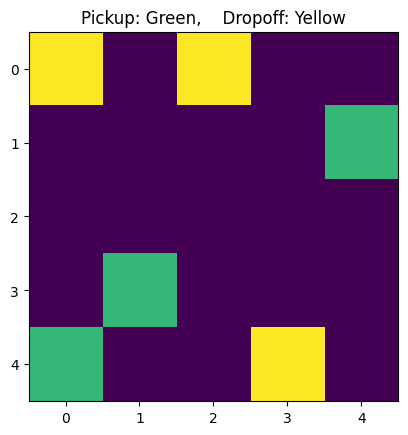

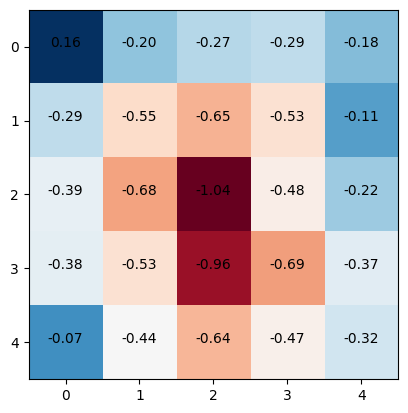

Steps completed. Reward =  -21836


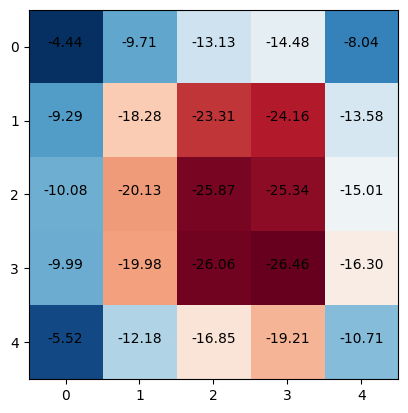

In [5]:
# Experiment 1B (Run first 500 steps)
# PGreedy policy

env_1B = PDWorld_env()
state = env_1B.reset()
print(state)

total_reward = 0
# Set a fixed seed for reproducibility
np.random.seed(42)

visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Run PRandom for the first 500 steps (1B)
for step in range(500):
    # Randomly select actions for each agent

    action = np.random.randint(0, env_1B.action_size)
    
    # Perform actions and calculate rewards
    state, reward = env_1B.step(action)  # Initial total reward is 0
    total_reward += reward
    
    
    # print(state)
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env_1B.is_done():
        print("Episode done at step", step + 1)
        break

env_1B.show_reward_grid()

for step in range(8500):
    actions = []

    for i in range(3):
            x, y = env_1B.agents[i]  # Extract x and y coordinates
            
                
            if (x, y) in env_1B.pickups and (x, y) in env_1B.blocks_on_ground and (not env_1B.carries_block[i]):
                action = 4
                

            if (x, y) in env_1B.dropoffs and env_1B.carries_block[i] and env_1B.blocks_on_ground.get((x, y), 0) < 4:
                action = 5
                

            else:
                key = env_1B.get_state()  # Convert the state into a hashable form
                # print(state)
                q_values = env_1B.get_q_values(i, key)
                # print(q_values)
                # env_1B.q_tables[i].setdefault(state, np.zeros(env_1B.action_size))
                # .setdefault(state, np.zeros(env_1B.action_size))
                

                best_actions = np.where(q_values == np.max(q_values))[0]
                # Break the tie
                action = np.random.choice(best_actions)
                # print(action)
                # if(action == 4):
                #     print("PICK UP", agent)
                # elif(action == 5):
                #     print("PUT DOWN")
            state, reward = env_1B.step(action)  # Initial total reward is 0
            total_reward += reward
            
    if env_1B.is_done():
        print("Episode done at step", step + 1)
        break
            

    

print("Steps completed. Reward = ", total_reward)

# env.show_reward_grid()
env_1B.show_reward_grid()

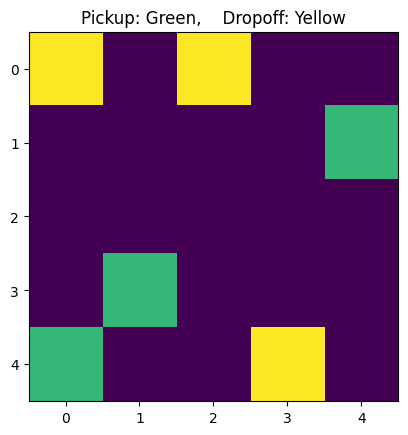

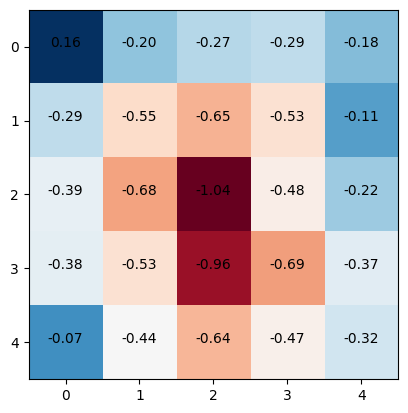

Steps completed. Reward =  -26430


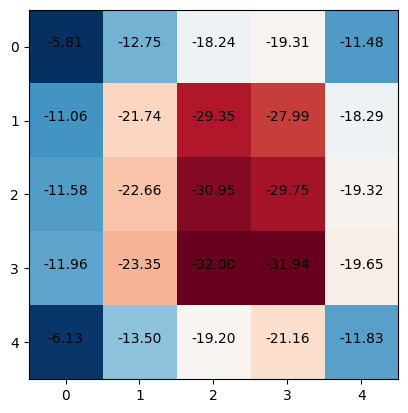

In [6]:
# Experiment 1C (Run first 500 steps)
# PExploit policy

env_1C = PDWorld_env()
state = env_1C.reset()

total_reward = 0
# Set a fixed seed for reproducibility
np.random.seed(42)

visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Run PRandom for the first 500 steps (1B)
for step in range(500):
    # Randomly select actions for each agent

    action = np.random.randint(0, env_1C.action_size)
    
    # Perform actions and calculate rewards
    state, reward = env_1C.step(action)  # Initial total reward is 0
    total_reward += reward
    
    
    # print(state)
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env_1C.is_done():
        print("Episode done at step", step + 1)
        break

env_1C.show_reward_grid()

for step in range(8500):
    actions = []

    for i in range(3):
            x, y = env_1C.agents[i]  # Extract x and y coordinates
            

            # PEXPLOIT policy
            if (x, y) in env.pickups and (x, y) in env.blocks_on_ground and not env.carries_block[i]:
                action = 4  

            if (x, y) in env.dropoffs and env.carries_block[i] and env.blocks_on_ground.get((x, y), 0) < 4:
                action = 5

        
            else:
                key = env_1C.get_state()  # Convert the state into a hashable form
                q_values = env_1C.get_q_values(i, key)
                best_actions = np.where(q_values == np.max(q_values))[0]
                
                if np.random.rand() < 0.2:
                    # Choose a different applicable operator randomly
                    available_actions = [a for a in range(env.action_size) if a not in [4, 5] or (a == 4 and (x, y) in env.pickups) or (a == 5 and (x, y) in env.dropoffs)]
                    action = np.random.choice(available_actions)
                else:
                    # Exploit: Choose the action with the highest Q-value
                    action = np.random.choice(best_actions)
            state, reward = env_1C.step(action)  # Initial total reward is 0
            total_reward += reward
                
    # Perform actions and calculate rewards
    
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)
    
    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed. Reward = ", total_reward)

# env.show_reward_grid()
env_1C.show_reward_grid()

#### Experiment 3 (Rerun experiment 1.C with alpha = 0.15)

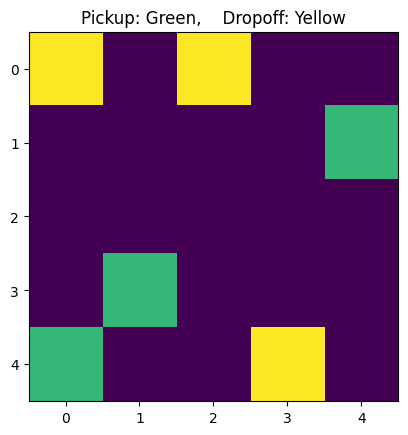

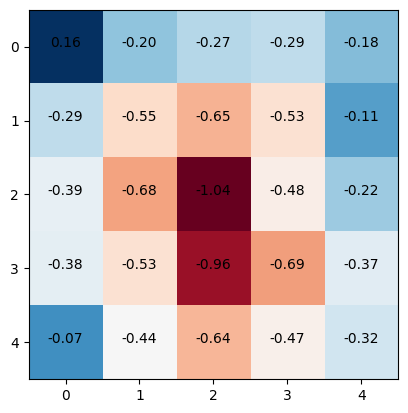

Steps completed with learning rate = 0.15. Reward =  -26561


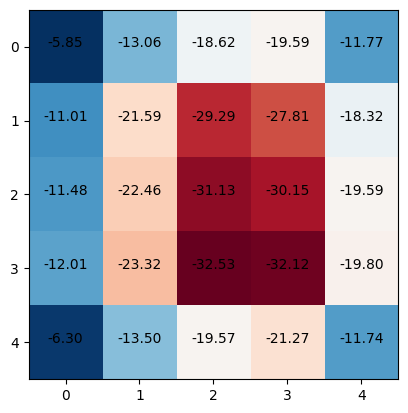

In [7]:
# Initialize with alpha=0.15
env_3_1 = PDWorld_env(alpha = 0.15)  

# Reset the environment to initialize the state
state = env_3_1.reset()
total_reward = 0

# Set a fixed seed for reproducibility
np.random.seed(42)

visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Run PRandom for the first 500 steps (1B)
for step in range(500):
    # Randomly select actions for each agent

    action = np.random.randint(0, env_3_1.action_size)
    
    # Perform actions and calculate rewards
    state, reward = env_3_1.step(action)  # Initial total reward is 0
    total_reward += reward
    
    
    # print(state)
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env_3_1.is_done():
        print("Episode done at step", step + 1)
        break

env_3_1.show_reward_grid()

# Next 8500 steps
for step in range(8500):
    actions = []

    for i in range(3):
            x, y = env_3_1.agents[i]  # Extract x and y coordinates
            

            # PEXPLOIT policy
            if (x, y) in env.pickups and (x, y) in env.blocks_on_ground and not env.carries_block[i]:
                action = 4  

            if (x, y) in env.dropoffs and env.carries_block[i] and env.blocks_on_ground.get((x, y), 0) < 4:
                action = 5

        
            else:
                key = env_3_1.get_state()  # Convert the state into a hashable form
                q_values = env_3_1.get_q_values(i, key)
                best_actions = np.where(q_values == np.max(q_values))[0]
                
                if np.random.rand() < 0.2:
                    # Choose a different applicable operator randomly
                    available_actions = [a for a in range(env.action_size) if a not in [4, 5] or (a == 4 and (x, y) in env.pickups) or (a == 5 and (x, y) in env.dropoffs)]
                    action = np.random.choice(available_actions)
                else:
                    # Exploit: Choose the action with the highest Q-value
                    action = np.random.choice(best_actions)
            state, reward = env_3_1.step(action)  # Initial total reward is 0
            total_reward += reward
                
    # Perform actions and calculate rewards
    
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)
    
    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed with learning rate = 0.15. Reward = ", total_reward)

# env.show_reward_grid()
env_3_1.show_reward_grid()

#### Experiment 3 (Rerun experiment 1.C with alpha = 0.45)

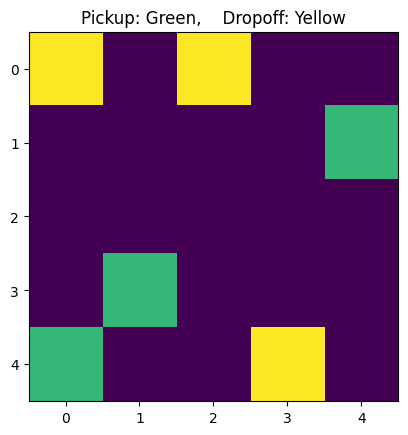

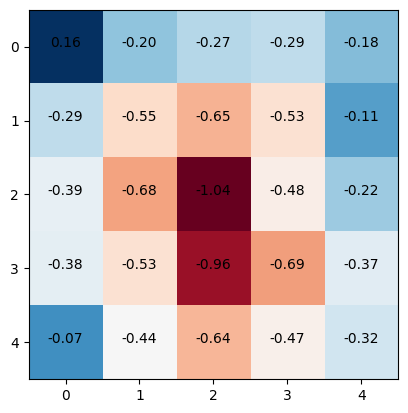

Steps completed with learning rate = 0.45. Reward =  -26471


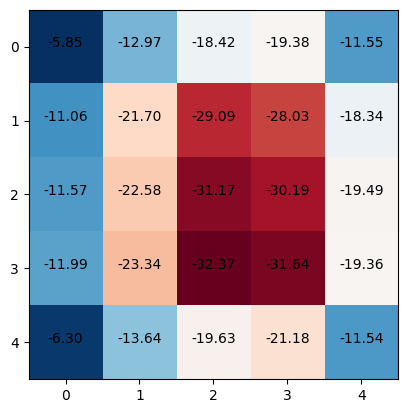

In [8]:
# Initialize with alpha=0.15
env_3_2 = PDWorld_env(alpha = 0.45)  

# Reset the environment to initialize the state
state = env_3_2.reset()
total_reward = 0

# Set a fixed seed for reproducibility
np.random.seed(42)

visualize_world_sansAgents(env.pickups, env.dropoffs, env.grid_size)

# Run PRandom for the first 500 steps (1B)
for step in range(500):
    # Randomly select actions for each agent

    action = np.random.randint(0, env_3_2.action_size)
    
    # Perform actions and calculate rewards
    state, reward = env_3_2.step(action)  # Initial total reward is 0
    total_reward += reward
    
    
    # print(state)
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)

    # Check if the episode is done
    if env_3_1.is_done():
        print("Episode done at step", step + 1)
        break

env_3_2.show_reward_grid()

# Next 8500 steps
for step in range(8500):
    actions = []

    for i in range(3):
            x, y = env_3_2.agents[i]  # Extract x and y coordinates
            

            # PEXPLOIT policy
            if (x, y) in env.pickups and (x, y) in env.blocks_on_ground and not env.carries_block[i]:
                action = 4  

            if (x, y) in env.dropoffs and env.carries_block[i] and env.blocks_on_ground.get((x, y), 0) < 4:
                action = 5

        
            else:
                key = env_3_2.get_state()  # Convert the state into a hashable form
                q_values = env_3_1.get_q_values(i, key)
                best_actions = np.where(q_values == np.max(q_values))[0]
                
                if np.random.rand() < 0.2:
                    # Choose a different applicable operator randomly
                    available_actions = [a for a in range(env.action_size) if a not in [4, 5] or (a == 4 and (x, y) in env.pickups) or (a == 5 and (x, y) in env.dropoffs)]
                    action = np.random.choice(available_actions)
                else:
                    # Exploit: Choose the action with the highest Q-value
                    action = np.random.choice(best_actions)
            state, reward = env_3_2.step(action)  # Initial total reward is 0
            total_reward += reward
                
    # Perform actions and calculate rewards
    
    # Print the total reward received after each step
    #print("Step:", step + 1, "Reward:", reward, "Agents: ", env.agents)
    
    # Check if the episode is done
    if env.is_done():
        print("Episode done at step", step + 1)
        break

print("Steps completed with learning rate = 0.45. Reward = ", total_reward)

# env.show_reward_grid()
env_3_2.show_reward_grid()